CNN Model final verson

In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tflearn
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tflearn.layers.conv import conv_2d, max_pool_2d, avg_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tflearn.data_augmentation import ImageAugmentation

TRAIN_DIR_PRE = '../datasets/train_images_denoised.npy'
TRAIN_LABEL_DIR = '../datasets/train_labels.csv'
TEST_DIR_PRE = '../datasets/test_images_denoised.npy'
IMG_SIZE = 35
MODEL_NAME = '3_layers'

Using TensorFlow backend.


In [2]:
#Name for categories
cate = ['sink','pear','moustache','nose','skateboard','penguin'
              ,'peanut','skull','panda','paintbrush','nail','apple',
              'rifle','mug','sailboat','pineapple','spoon','rabbit',
              'shovel','rollerskates','screwdriver','scorpion','rhinoceros'
              ,'pool','octagon','pillow','parrot','squiggle','mouth',
               'empty','pencil']
categories = {0:'apple',1:'empty',2:'moustache', 3:'mouth', 4:'mug', 5:'nail', 6:'nose'\
              ,7:'octagon', 8:'paintbrush', 9:'panda', 10:'parrot',11:'peanut',\
              12:'pear', 13:'pencil', 14:'penguin',15:'pillow',16:'pineapple',17:'pool'\
              ,18:'rabbit', 19:'rhinoceros',20:'rifle',21:'rollerskates',22:'sailboat',\
              23:'scorpion',24:'screwdriver', 25:'shovel', 26:'sink', 27:'skateboard',\
              28:'skull',29:'spoon',30:'squiggle'}
from sklearn import preprocessing
#This will give a 1-of-k coding scheme with alphbat sequence
lb = preprocessing.LabelBinarizer()
lb.fit(cate)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [3]:
#Notice here preprocessed image as input
train_raw = np.load(TRAIN_DIR_PRE, encoding = 'latin1')
train_label = np.array(pd.read_csv(TRAIN_LABEL_DIR, delimiter=","))
final_test = np.load(TEST_DIR_PRE,encoding='latin1')

train_label = train_label[:,1]
train_data = []
for i in range(len(train_label)):
    encoded = lb.transform([train_label[i]])
    train_data.append([np.array(train_raw[:,1][i]), encoded[0]])

#Split train data into train, validation and test data
import random
#random.shuffle(train_data)
train = train_data[:8000]
valid = train_data[8000:9000]
test = train_data[9000:]


In [4]:
#reshaping data
train_x = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
train_y = [i[1] for i in train]
train_y = np.reshape(train_y,(-1,31))


valid_x = np.array([i[0] for i in valid]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
valid_y = np.array([i[1] for i in valid]).reshape(-1,31)

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = np.array([i[1] for i in test]).reshape(-1,31)

#the shape of preprocessed test set is (10000,2) idx 0: img, idx 1:id
final_test = final_test[:,1]
final_test_x = np.array([i for i in final_test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)

In [30]:
def create_model(dp_rate, fl_size, ln_rate, nb_fr):
    tf.reset_default_graph()
    img_aug = ImageAugmentation()
    img_aug.add_random_flip_leftright()
    img_aug.add_random_rotation(max_angle=30.0)

    convent = input_data(shape = [None, IMG_SIZE, IMG_SIZE, 1],name = 'input',data_augmentation=img_aug)

    convent = conv_2d(convent, nb_filter = nb_fr[0], filter_size = 2, activation = 'relu',padding='same',regularizer='L2')
    convent = avg_pool_2d(convent, 2)

    convent = conv_2d(convent, nb_filter = nb_fr[1], filter_size = fl_size, activation = 'relu',padding='same',regularizer='L2')
    convent = avg_pool_2d(convent, 2)

    convent = conv_2d(convent, nb_filter = nb_fr[2], filter_size = fl_size, activation = 'relu',padding='same',regularizer='L2')
    convent = avg_pool_2d(convent, 2)

    convent = fully_connected(convent, 1024, activation = 'relu')
    convent = dropout(convent, dp_rate)
    
    convent = fully_connected(convent, 1024, activation = 'relu')
    convent = dropout(convent, dp_rate)

    convent = fully_connected(convent, 31, activation ='softmax')
    convent = regression(convent, optimizer = 'Adam', learning_rate = ln_rate, loss='categorical_crossentropy', name = 'target')

    model = tflearn.DNN(convent, tensorboard_dir = 'log')
    return model

In [32]:
model= create_model(0.5, 3, 0.0005, [64,128,256,512])
model.fit(train_x, train_y, n_epoch =60, validation_set = (valid_x,valid_y),
              snapshot_step=200, show_metric=True)

Training Step: 7499  | total loss: 0.43023 | time: 12.078s
| Adam | epoch: 060 | loss: 0.43023 - acc: 0.8627 -- iter: 7936/8000
Training Step: 7500  | total loss: 0.44134 | time: 13.190s
| Adam | epoch: 060 | loss: 0.44134 - acc: 0.8577 | val_loss: 1.03904 - val_acc: 0.7490 -- iter: 8000/8000
--


In [79]:
model.save(MODEL_NAME)

INFO:tensorflow:/home/ubuntu/comp551/kaggle/classify-doodles/code/77+ is not in all_model_checkpoint_paths. Manually adding it.


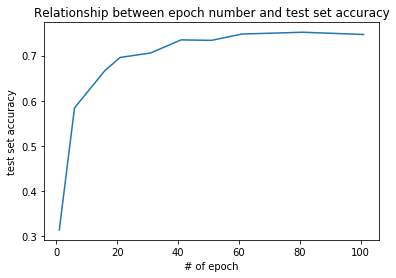

In [21]:
#model= create_model(0.3, 3, 0.0005, [64,128,256,512])
#epnum = []
#acc = []
#model.fit(train_x, train_y, n_epoch =1, validation_set = (valid_x,valid_y),
                  #snapshot_step=200, show_metric=True)
#epnum.append(1)
#acc.append(model.evaluate(test_x, test_y))
#for i in range(5):
#    ep = 5*i    
#    epnum.append(ep)
#    model.fit(train_x, train_y, n_epoch =ep, validation_set = (valid_x,valid_y),
#                  snapshot_step=200, show_metric=True)
#    accnum = model.evaluate(test_x, test_y)
#    acc.append(accnum)
    
epnum = [1, 6, 16, 21, 31,41, 51,61,81 ,101]
acc = [0.3129999990463257, 0.5839999971389771, 0.6669999990463257,0.6960000014305114, 0.7060000028610229,
       0.7349999995231629, 0.7339999980926514,0.747999997138977, 0.7520000019073486, 0.7469999980926514]
import matplotlib.pyplot as plt
plt.plot(epnum, acc, '-')
plt.xlabel('# of epoch')
plt.ylabel('test set accuracy')
plt.title('Relationship between epoch number and test set accuracy')
plt.show()

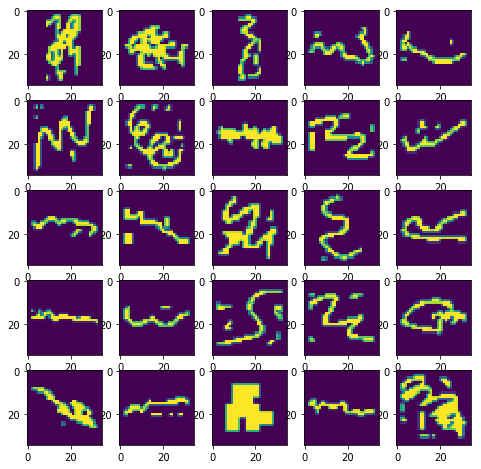

In [22]:
imgs = []
parrot = []
for num, data in enumerate(train_label):
    if(data =='squiggle'):
        img = train_data[num][0]
        imgs.append(img)
        parrot.append(train_data[num])
w=10
h=10
columns =5
rows = 5
fig=plt.figure(figsize=(8, 8))
for i in range(1, columns*rows +1):
    img = imgs[i].reshape(IMG_SIZE,IMG_SIZE)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [25]:
from sklearn import datasets, svm, metrics
pred = model.predict(test_x).argmax(axis = -1)
true = test_y.argmax(axis = -1)
from sklearn.metrics import classification_report
names = ['apple','empty','moustache','mouth','mug','nail','nose','octagon','paintbrush','panda','parrot','peanut',
         'pear','pencil','penguin','pillow','pineapple','pool','rabbit','rhinoceros','rifle','rollerskates','sailboat',
         'scorpion','screwdriver','shovel','sink','skateboard','skull','spoon','squiggle']
print(classification_report(true, pred, target_names=names))

              precision    recall  f1-score   support

       apple       0.90      0.84      0.87        43
       empty       0.70      0.85      0.77        33
   moustache       0.69      0.80      0.74        44
       mouth       0.78      0.91      0.84        57
         mug       0.81      0.81      0.81        31
        nail       0.89      0.69      0.78        45
        nose       0.73      0.85      0.79        26
     octagon       0.81      0.74      0.78        47
  paintbrush       0.63      0.76      0.69        25
       panda       0.72      0.57      0.63        23
      parrot       0.54      0.64      0.58        11
      peanut       0.64      0.67      0.65        21
        pear       0.75      0.64      0.69        28
      pencil       0.50      0.72      0.59        25
     penguin       0.57      0.72      0.64        29
      pillow       0.74      0.58      0.65        24
   pineapple       0.77      0.85      0.81        47
        pool       0.71    

In [28]:
acc = 0
wrong = []
for num, data in enumerate(test):
    img_num = data[1]
    img_data = data[0]
  
    orig = img_data.reshape(IMG_SIZE, IMG_SIZE)
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
  

    model_out = model.predict([data])[0]  
    prediction = model_out.argmax(axis=-1)
  
    true = img_num.argmax(axis=-1)
    if(prediction == true): acc+=1
    else: wrong.append([num, true, prediction])
result = acc/(len(test))
print('This is the test set accuracy: ' + str(result))

This is the test set accuracy: 0.74


In [ ]:
#Generate Results
pred_test = model.predict(final_test_x[:3000]).argmax(axis=-1)
pred_test_p2 = model.predict(final_test_x[3000:6000]).argmax(axis=-1)
pred_test_p3 = model.predict(final_test_x[6000:]).argmax(axis=-1)
pred_test = np.hstack([pred_test,pred_test_p2,pred_test_p3])
import csv
with open("../output/submit_n.csv","w") as f:
    wt = csv.writer(f,delimiter=',')
    wt.writerow(['Id','Category'])
    for idx,i in enumerate(pred_test):
        wt.writerow([str(idx),str(categories.get(i))])